In [1]:
# Importing all the necessary packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from arch import arch_model
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.stats.diagnostic import het_arch
import pandas as pd
from pandas.errors import PerformanceWarning
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima.arima import ndiffs, nsdiffs
from statsmodels.tsa.arima.model import ARIMA


# For legibility, we mute some warnings
import warnings

# Ignore FutureWarning for deprecated 'T' frequency in Prophet
warnings.filterwarnings("ignore", category=FutureWarning, message="'T' is deprecated")

# Ignore PerformanceWarning from pandas
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [3]:
merged_df = pd.read_csv('merged_df_Combined.csv')

In [4]:
merged_df.head()

,Datetime,Total_Load,Demand_Outturn,Biomass,Fossil_Gas,Fossil_Hard_Coal,Fossil_Oil,BSAD_Turn_Up,BSAD_Turn_Down,EPEX_Intraday_Volume,...,Day_Ahead_Price,Intraday_Price,System_Price,BM_Bid_Acceptances,BM_Offer_Acceptances,NIV_Outturn,Hydro_Pumped_Storage,Hydro_Run-of-River_and_Poundage,Nuclear,Solar
0,2018-01-01T00:00:00,30303.0,26413.0,710.0,5190.0,1143.0,0.0,1104.0,-900.0,781.35,...,46.73,47.27,55.94,-1833.86,1910.98,-77.05,0.0,352.0,7263.0,0.0
1,2018-01-01T00:30:00,31096.0,27130.0,749.0,5574.0,1308.0,0.0,1104.0,-900.0,655.40,...,50.11,48.57,55.94,-1443.78,1778.09,-334.76,0.0,351.0,7268.0,0.0
2,2018-01-01T01:00:00,30599.0,27378.0,756.0,5753.0,1461.0,0.0,1104.0,-900.0,821.50,...,56.60,52.32,62.94,-1580.12,1799.90,-219.78,206.0,355.0,7260.0,0.0
3,2018-01-01T01:30:00,29402.0,26746.0,757.0,5616.0,1587.0,0.0,1104.0,-900.0,815.20,...,51.83,51.18,31.00,-1699.05,1413.04,286.63,0.0,349.0,7258.0,0.0
4,2018-01-01T02:00:00,28096.0,26169.0,747.0,5192.0,1591.0,0.0,1104.0,-1050.0,709.05,...,46.23,46.08,60.81,-1413.27,1554.31,-141.41,0.0,340.0,7264.0,0.0


In [ ]:
correlations = merged_df.drop(columns=['Datetime']).corrwith(merged_df['System_Price']).abs().sort_values(ascending = False)

In [19]:
correlations[:12]

System_Price            1.000000
Intraday_Price          0.810647
Day_Ahead_Price         0.685809
NIV_Outturn             0.327428
BSAD_Total              0.270154
BM_Bid_Acceptances      0.231037
BSAD_Turn_Down          0.228765
Nuclear                 0.201872
Demand_Outturn          0.172817
Hydro_Pumped_Storage    0.165744
Fossil_Gas              0.138025
BSAD_Turn_Up            0.132108
dtype: float64

In [ ]:
# using this to set the feautures to detect outliers 
top_features = correlations.abs().sort_values(ascending=False).iloc[1:11].index.tolist()

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Calculate thresholds for outliers
lower_threshold = merged_df['System_Price'].quantile(0.05)
upper_threshold = merged_df['System_Price'].quantile(0.95)

# Define Outlier Labels
merged_df['Upward_Outlier'] = (merged_df['System_Price'] > upper_threshold).astype(int)
merged_df['Downward_Outlier'] = (merged_df['System_Price'] < lower_threshold).astype(int)

# Define Features (X) and Targets (y)
X = merged_df[top_features]
y_up = merged_df['Upward_Outlier']
y_down = merged_df['Downward_Outlier']

# Train-Test Split for Upward Outliers
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X, y_up, test_size=0.3, random_state=0)

# Train XGBoost Classifier for Upward Outliers
xgb_up = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
xgb_up.fit(X_train_up, y_train_up)

# Predict and Evaluate for Upward Outliers
y_pred_up = xgb_up.predict(X_test_up)
print("XGBoost - Upward Outliers Classification Report:")
print(classification_report(y_test_up, y_pred_up))

# Train-Test Split for Downward Outliers
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X, y_down, test_size=0.3, random_state=0)

# Train XGBoost Classifier for Downward Outliers
xgb_down = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_down.fit(X_train_down, y_train_down)

# Predict and Evaluate for Downward Outliers
y_pred_down = xgb_down.predict(X_test_down)
print("XGBoost - Downward Outliers Classification Report:")
print(classification_report(y_test_down, y_pred_down))


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:03:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Upward Outliers Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33788
           1       0.90      0.86      0.88      1708

    accuracy                           0.99     35496
   macro avg       0.94      0.93      0.93     35496
weighted avg       0.99      0.99      0.99     35496



/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:03:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Downward Outliers Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     33767
           1       0.80      0.58      0.67      1729

    accuracy                           0.97     35496
   macro avg       0.89      0.78      0.83     35496
weighted avg       0.97      0.97      0.97     35496



In [ ]:
# using the top features only but ideally it would be best to use the final features used for the classification
top_features = correlations.abs().sort_values(ascending=False).iloc[:11].index.tolist()

In [ ]:
# scaling because you need to for isolation forest 
data_to_scale = merged_df[top_features]

In [27]:
data_to_scale

,System_Price,Intraday_Price,Day_Ahead_Price,NIV_Outturn,BSAD_Total,BM_Bid_Acceptances,BSAD_Turn_Down,Nuclear,Demand_Outturn,Hydro_Pumped_Storage,Fossil_Gas
0,55.94,47.27,46.73,-77.05,204.000000,-1833.86,-900.000000,7263.0,26413.0,0.0,5190.0
1,55.94,48.57,50.11,-334.76,204.000000,-1443.78,-900.000000,7268.0,27130.0,0.0,5574.0
2,62.94,52.32,56.60,-219.78,204.000000,-1580.12,-900.000000,7260.0,27378.0,206.0,5753.0
3,31.00,51.18,51.83,286.63,204.000000,-1699.05,-900.000000,7258.0,26746.0,0.0,5616.0
4,60.81,46.08,46.23,-141.41,54.000000,-1413.27,-1050.000000,7264.0,26169.0,0.0,5192.0
...,...,...,...,...,...,...,...,...,...,...,...
118315,57.40,77.12,78.00,79.14,372.977641,-1303.27,-12.348965,4391.0,25816.0,74.0,2986.0
118316,62.78,62.78,81.00,-210.78,-50.000000,-1923.57,-500.000000,4393.0,24630.0,0.0,2908.0
118317,29.50,55.46,81.00,0.96,-50.000000,-2093.07,-500.000000,4394.0,24255.0,0.0,2754.0
118318,52.88,52.88,68.80,-749.51,-50.000000,-1392.78,-500.000000,4397.0,23896.0,0.0,2630.0


In [22]:
# trying isolation forest 
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np

In [28]:
from sklearn.preprocessing import StandardScaler

# Assuming `data` is your dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)  # Scaled dataset

In [29]:
iso_forest = IsolationForest(
    n_estimators=1000, 
    contamination=0.05,  # Adjust based on expected proportion of anomalies
    random_state=0
)

In [30]:
iso_forest.fit(scaled_data)

IsolationForest(contamination=0.05, n_estimators=1000, random_state=0)

In [31]:
# Predict outliers
predictions = iso_forest.predict(scaled_data)

# Anomaly scores (lower scores indicate more anomalous points)
anomaly_scores = iso_forest.decision_function(scaled_data)

# Add predictions and scores to your dataframe
merged_df['anomaly'] = predictions
merged_df['anomaly_score'] = anomaly_scores

In [ ]:
# -1 for outliers and 1 for normal points 
outliers = merged_df[merged_df['anomaly'] == -1]
print(outliers)


                   Datetime  Total_Load  Demand_Outturn  Biomass  Fossil_Gas  \
226     2018-01-05T17:00:00     49672.0         47104.0    729.0     24510.0   
227     2018-01-05T17:30:00     49183.0         47123.0    731.0     24645.0   
362     2018-01-08T13:00:00     50895.0         46071.0    681.0     22533.0   
363     2018-01-08T13:30:00     50951.0         45852.0    681.0     23001.0   
364     2018-01-08T14:00:00     50447.0         45826.0    680.0     22866.0   
...                     ...         ...             ...      ...         ...   
116456  2024-08-23T04:00:00     18655.0         20176.0    567.0      2928.0   
117530  2024-09-14T13:00:00     26196.0         19925.0   1166.0      2667.0   
117531  2024-09-14T13:30:00     25684.0         19708.0   1129.0      2342.0   
117532  2024-09-14T14:00:00     25260.0         19996.0   1118.0      2444.0   
117533  2024-09-14T14:30:00     25516.0         20761.0   1115.0      2918.0   

        Fossil_Hard_Coal  Fossil_Oil  B

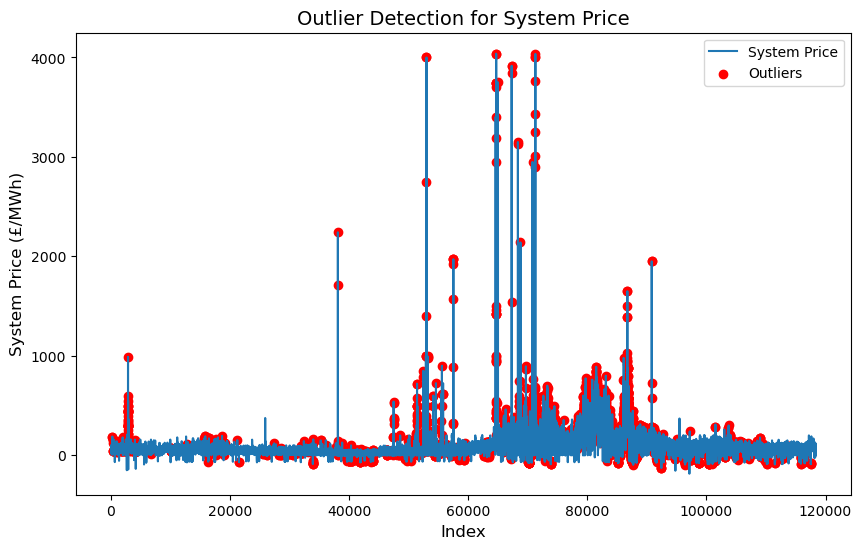

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the target variable
plt.plot(merged_df['System_Price'], label='System Price')

# Highlight the outliers
plt.scatter(
    merged_df[merged_df['anomaly'] == -1].index, 
    merged_df[merged_df['anomaly'] == -1]['System_Price'], 
    color='red', 
    label='Outliers'
)

# Add title, labels, and legend
plt.title('Outlier Detection for System Price', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('System Price (£/MWh)', fontsize=12)
plt.legend()
plt.show()


In [35]:
# trying LOF
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import numpy as np

In [ ]:
# Initialize LOF with Minkowski distance (p=2 is Euclidean), i want to use euclidean because it will penalize larger deviations from cluster, another option is to square data because the LOF doesnt support squared euclidean which would penalize high deviations from the cluster  
lof = LocalOutlierFactor(
    n_neighbors=20,         # Number of neighbors to compare densities
    contamination=0.05,     # Proportion of expected outliers
    metric='minkowski',     # Minkowski distance
    p=2                     # p=2 corresponds to Euclidean distance
)

In [37]:
# Fit the LOF model and predict
predictions = lof.fit_predict(scaled_data)  # LOF predicts directly
anomaly_scores = lof.negative_outlier_factor_  # LOF scores for each point

# Add predictions and scores to your DataFrame
merged_df['anomaly_LOF'] = predictions  # -1 for outliers, 1 for normal points
merged_df['lof_score'] = -anomaly_scores  # Higher values indicate stronger anomalies


In [38]:
outliers = merged_df[merged_df['anomaly_LOF'] == -1]
print(outliers)

                   Datetime  Total_Load  Demand_Outturn  Biomass  Fossil_Gas  \
2       2018-01-01T01:00:00     30599.0         27378.0    756.0      5753.0   
16      2018-01-01T08:00:00     27325.0         25050.0    757.0      6070.0   
17      2018-01-01T08:30:00     28484.0         26217.0    758.0      6973.0   
18      2018-01-01T09:00:00     31217.0         27494.0    756.0      7531.0   
19      2018-01-01T09:30:00     32480.0         28640.0    747.0      9085.0   
...                     ...         ...             ...      ...         ...   
117326  2024-09-10T07:00:00     32307.0         28428.0   1186.0      5482.0   
117327  2024-09-10T07:30:00     33312.0         28665.0   1181.0      5727.0   
117476  2024-09-13T10:00:00     38317.0         25656.0   3173.0      7101.0   
117721  2024-09-18T12:30:00     37858.0         23719.0   2219.0      5562.0   
118308  2024-09-30T18:00:00     40985.0         35066.0   2535.0      9903.0   

        Fossil_Hard_Coal  Fossil_Oil  B

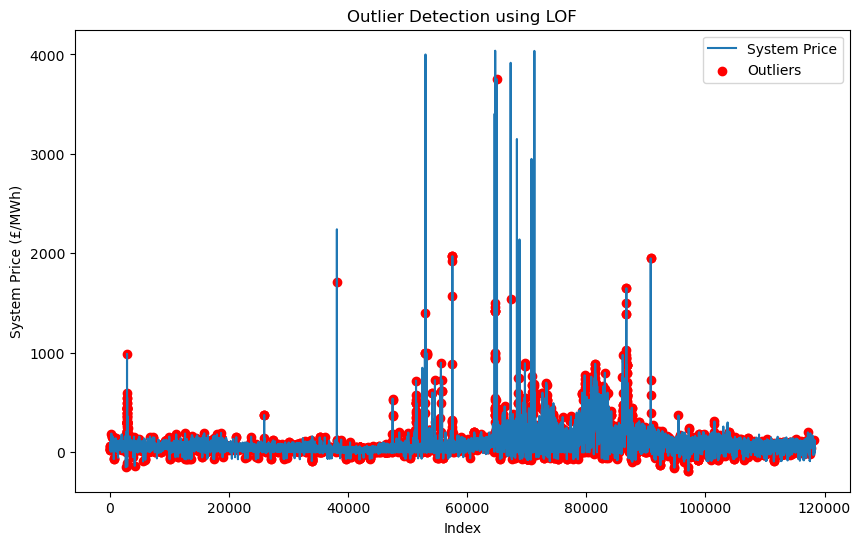

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(merged_df['System_Price'], label='System Price')
plt.scatter(merged_df[merged_df['anomaly_LOF'] == -1].index, 
            merged_df[merged_df['anomaly_LOF'] == -1]['System_Price'], 
            color='red', label='Outliers')
plt.title('Outlier Detection using LOF')
plt.xlabel('Index')
plt.ylabel('System Price (£/MWh)')
plt.legend()
plt.show()
